<a href="https://colab.research.google.com/github/pereisergio/TensorFlow-Serving/blob/main/API_de_Classifica%C3%A7%C3%A3o_de_Imagens_com_TensorFlow_Serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Etapa 1: Instalação das bibliotecas

In [3]:
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2943  100  2943    0     0  17893      0 --:--:-- --:--:-- --:--:-- 17945
OK


In [40]:
!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb'
!dpkg -i tensorflow-model-server-universal_2.8.0_all.deb

--2024-07-16 17:45:20--  http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335421916 (320M) [application/x-debian-package]
Saving to: ‘tensorflow-model-server-universal_2.8.0_all.deb.2’

tensorflow-model-se 100%[===================>] 319.88M  28.6MB/s    in 6.1s    

2024-07-16 17:45:26 (52.1 MB/s) - ‘tensorflow-model-server-universal_2.8.0_all.deb.2’ saved [335421916/335421916]

dpkg: error: need an action option

Type dpkg --help for help about installing and deinstalling packages [*];
Use 'apt' or 'aptitude' for user-friendly package management;
Type dpkg -Dhelp for a list of dpkg debug flag valu

In [41]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package tensorflow-model-server


In [5]:
!pip install requests

## Etapa 2: Importação das bibliotecas

In [6]:
import os
import json
import random
import requests
import subprocess
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

%matplotlib inline
tf.__version__

Instructions for updating:
non-resource variables are not supported in the long term


'2.15.0'

## Etapa 3: Pré-processamento

### Carregando a base de dados

In [7]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 5s 0us/step


In [8]:
class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Normalização das imagens

In [9]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [10]:
X_train.shape

(50000, 32, 32, 3)

In [11]:
X_test.shape

(10000, 32, 32, 3)

## Etapa 4: Definição do modelo

NOTA: Estamos usando o mesmo modelo da seção sobre Redes Neurais Convolucionais

In [12]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

### Compilando o modelo

In [13]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

### Treinando o modelo

In [14]:
model.fit(X_train,
          y_train,
          batch_size=32,
          epochs=10)

Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 11s 210us/sample - loss: 1.4085 - sparse_categorical_accuracy: 0.4919
Epoch 2/10
50000/50000 [==============================] - 6s 124us/sample - loss: 0.9365 - sparse_categorical_accuracy: 0.6700
Epoch 3/10
50000/50000 [==============================] - 7s 131us/sample - loss: 0.7536 - sparse_categorical_accuracy: 0.7354
Epoch 4/10
50000/50000 [==============================] - 6s 127us/sample - loss: 0.6272 - sparse_categorical_accuracy: 0.7803
Epoch 5/10
50000/50000 [==============================] - 7s 132us/sample - loss: 0.5213 - sparse_categorical_accuracy: 0.8163
Epoch 6/10
50000/50000 [==============================] - 6s 127us/sample - loss: 0.4231 - sparse_categorical_accuracy: 0.8518
Epoch 7/10
50000/50000 [==============================] - 7s 130us/sample - loss: 0.3306 - sparse_categorical_accuracy: 0.8826
Epoch 8/10
50000/50000 [==============================] - 6s 128us/sample - loss: 0.263

### Avaliação do modelo

In [15]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy is {}".format(test_accuracy))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Test accuracy is 0.7143999934196472


## Etapa 5: Salvando o modelo para produção

### Criando o diretório para o modelo

In [16]:
model_dir = 'model/'
version = 1

In [17]:
export_path = os.path.join(model_dir, str(version))
print('export_path = {}\n'.format(export_path))

export_path = model/1



In [18]:
if os.path.isdir(export_path):
  !rm -r {export_path}

### Salvando o modelo para o TensorFlow Serving

In [19]:
tf.saved_model.simple_save(tf.keras.backend.get_session(),
                           export_dir = export_path,
                           inputs = {'input_image': model.input},
                           outputs = {t.name: t for t in model.outputs})

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


## Etapa 6: Configuração do ambiente de produção

### Exportando o MODEL_DIR para as variáveis de ambiente

In [46]:
os.environ['MODEL_DIR'] = os.path.abspath(model_dir)

### Executando a API TensorFlow Serving REST

In [47]:
%%bash --bg
nohup tensorflow_model_server --rest_api_port=8501 --model_name=cifar10 --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [48]:
!tail server.log

2024-07-16 17:48:59.968788: E external/org_tensorflow/tensorflow/core/framework/node_def_util.cc:630] NodeDef mentions attribute debug_name which is not in the op definition: Op<name=VarHandleOp; signature= -> resource:resource; attr=container:string,default=""; attr=shared_name:string,default=""; attr=dtype:type; attr=shape:shape; attr=allowed_devices:list(string),default=[]; is_stateful=true> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node dense/kernel}}
[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...


## Etapa 7: Criando a primeira requisição POST

In [119]:
random_image = np.random.randint(0, len(X_test))

In [120]:
random_image

1000

### Criando o objeto JSON

In [121]:
data = json.dumps({"signature_name": "serving_default", "instances": X_test[random_image:random_image+1].tolist()})

In [122]:
data

'{"signature_name": "serving_default", "instances": [[[[0.07058823529411765, 0.06666666666666667, 0.050980392156862744], [0.0784313725490196, 0.0784313725490196, 0.058823529411764705], [0.08235294117647059, 0.08627450980392157, 0.06666666666666667], [0.08235294117647059, 0.08627450980392157, 0.0784313725490196], [0.07450980392156863, 0.0784313725490196, 0.0784313725490196], [0.08627450980392157, 0.0784313725490196, 0.08235294117647059], [0.09411764705882353, 0.0784313725490196, 0.08235294117647059], [0.08235294117647059, 0.07058823529411765, 0.07450980392156863], [0.058823529411764705, 0.058823529411764705, 0.058823529411764705], [0.0784313725490196, 0.0784313725490196, 0.0784313725490196], [0.10588235294117647, 0.09019607843137255, 0.09411764705882353], [0.09411764705882353, 0.08627450980392157, 0.09411764705882353], [0.07058823529411765, 0.06274509803921569, 0.07450980392156863], [0.17254901960784313, 0.12156862745098039, 0.10196078431372549], [0.3215686274509804, 0.23529411764705882

### Enviando a primeira requisição POST para o modelo

In [123]:
headers = {"content-type": "application/json"}

In [124]:
json_response = requests.post(url='http://localhost:8501/v1/models/cifar10:predict', data=data, headers=headers)

In [125]:
json_response

<Response [200]>

In [126]:
predictions = json.loads(json_response.text)['predictions']

In [127]:
predictions

[[2.02303695e-11,
  1.99661532e-09,
  3.45605122e-06,
  0.00115907553,
  1.3472393e-08,
  0.998357475,
  0.000343655352,
  0.000136258488,
  8.43242712e-14,
  1.38379808e-10]]

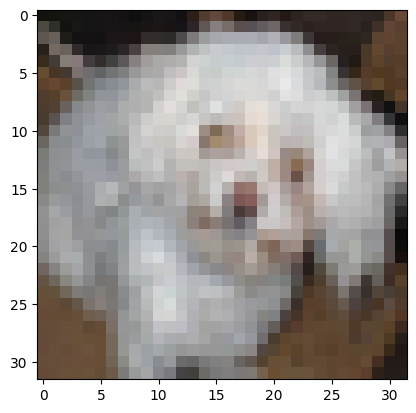

In [128]:
plt.imshow(X_test[random_image])

In [129]:
class_name[np.argmax(predictions[0])]

'dog'

## Etapa 8: Enviando a requisição POST para um modelo específico que está armazendo no servidor

In [130]:
specif_json_response = requests.post(url='http://localhost:8501/v1/models/cifar10/versions/1:predict', data=data, headers=headers)

In [131]:
specif_json_response

<Response [200]>

In [132]:
predictions = json.loads(json_response.text)['predictions']

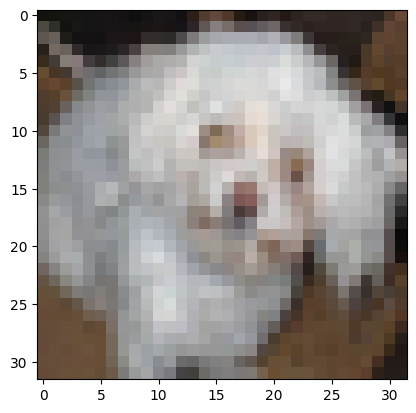

'dog'

In [133]:
plt.imshow(X_test[random_image])
plt.show();
class_name[np.argmax(predictions[0])]